In [44]:
using Flux
using Measurements
using Plots

Consider a nonlinear, multivariable function:

\begin{equation}
    f(x, y) = x^5 + y^4 - x^4 - y^3
\end{equation}

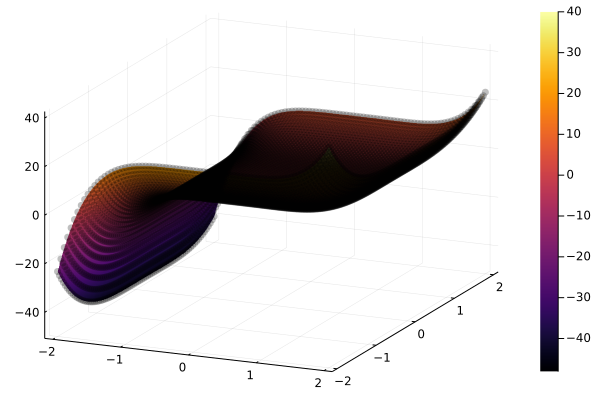

In [45]:
f(x,y) = x^5 + y^4 - x^4 - y^3

x = -2:0.05:2
y = -2:0.05:2 

X = [x[i] for i∈1:length(x), j∈1:length(y)]
Y = [y[j] for i∈1:length(x), j∈1:length(y)]

p1 = plot(x, y, f,st=:surf, camera=(30,45))
scatter!(p1, X, Y, f.(X, Y), color=:black, alpha=0.25, label="", camera=(30, 45))
#plot(p1, p2, figsize=(20,10))

Now let's augment the data with uncertainties. 

In [46]:
x = [xi±0.1 for xi∈-2:0.05:2]
y = [yi±0.25 for yi∈-2:0.05:2]

X = [x[i] for i∈1:length(x), j∈1:length(y)]
Y = [y[j] for i∈1:length(x), j∈1:length(y)]

X_in = reshape(X, size(X)[1]*size(X)[2])
Y_in = reshape(Y, size(Y)[1]*size(Y)[2])

F = f.(Measurements.value.(X_in), Measurements.value.(Y_in))

6561-element Vector{Float64}:
 -24.0
 -18.654068437499994
 -13.793089999999992
  -9.383492812500009
  -5.393280000000004
  -1.7919921875
   1.4493300000000033
   4.3581834375000055
   6.960639999999994
   9.281384062499999
  11.34375
  13.169759687500001
  14.780160000000002
   ⋮
   9.989227812500001
  10.53125
  11.1746034375
  11.93216
  12.817804062499999
  13.846469999999997
  15.0341796875
  16.398079999999997
  17.956480312500005
  19.728889999999993
  21.7360559375
  24.0

Create training and test datasets

In [79]:
train_frac = 0.85
test_frac = 0.15

idx = 1:length(X_in)


1:6561

In [97]:
using StatsBase

use `sample` from `StatsBase` combined with the `setdifference` operation to easily generate a train-test split.

In [94]:
idx_test = sample(collect(idx), Int(round(test_frac*length(X_in))), replace=false)
idx_train = collect(setdiff(Set(idx), Set(idx_test)))
println(length(idx_train), " ", length(idx_test), " ", length(idx))

5577 984 6561


In [102]:
X_test = X_in[idx_test]
Y_test = Y_in[idx_test]
F_test = F[idx_test]

X_train = X_in[idx_train]
Y_train = X_in[idx_train]
F_train = F[idx_train]

Test = [[X_test[i], Y_test[i]] for i ∈ 1:length(X_test)]
Train = [[X_train[i], Y_train[i]] for i ∈ 1:length(X_train)]


5577-element Vector{Vector{Measurement{Float64}}}:
 [0.2 ± 0.1, 0.2 ± 0.1]
 [-1.95 ± 0.1, -1.95 ± 0.1]
 [-0.05 ± 0.1, -0.05 ± 0.1]
 [1.9 ± 0.1, 1.9 ± 0.1]
 [-1.05 ± 0.1, -1.05 ± 0.1]
 [-1.95 ± 0.1, -1.95 ± 0.1]
 [-1.45 ± 0.1, -1.45 ± 0.1]
 [-2.0 ± 0.1, -2.0 ± 0.1]
 [1.05 ± 0.1, 1.05 ± 0.1]
 [-1.85 ± 0.1, -1.85 ± 0.1]
 [0.0 ± 0.1, 0.0 ± 0.1]
 [-0.1 ± 0.1, -0.1 ± 0.1]
 [-0.9 ± 0.1, -0.9 ± 0.1]
 ⋮
 [-1.95 ± 0.1, -1.95 ± 0.1]
 [-0.5 ± 0.1, -0.5 ± 0.1]
 [1.8 ± 0.1, 1.8 ± 0.1]
 [1.55 ± 0.1, 1.55 ± 0.1]
 [-1.0 ± 0.1, -1.0 ± 0.1]
 [-0.05 ± 0.1, -0.05 ± 0.1]
 [-1.55 ± 0.1, -1.55 ± 0.1]
 [-0.75 ± 0.1, -0.75 ± 0.1]
 [0.0 ± 0.1, 0.0 ± 0.1]
 [-0.65 ± 0.1, -0.65 ± 0.1]
 [1.0 ± 0.1, 1.0 ± 0.1]
 [1.45 ± 0.1, 1.45 ± 0.1]

Now let's train a neural network to predict the function and see how it will work. 

In [106]:
# simple model with 30 hidden neurons
model = Chain(Dense(2, 30, σ), Dense(30, 1))

Chain(Dense(2, 30, σ), Dense(30, 1))

In [135]:
# flux works with measurments! 
model.(Train[1:10])

10-element Vector{Vector{Measurement{Float64}}}:
 [0.3694 ± 0.0088]
 [0.5441 ± 0.0067]
 [0.3914 ± 0.0088]
 [0.2332 ± 0.0068]
 [0.477 ± 0.0081]
 [0.5441 ± 0.0067]
 [0.5084 ± 0.0076]
 [0.5474 ± 0.0066]
 [0.2969 ± 0.0081]
 [0.5373 ± 0.0069]

Define the loss function as the mse for the value (ignoring the error to start) 

In [153]:
loss(x, y) = Flux.Losses.mse(Measurements.value.(model(x)), y)

loss (generic function with 1 method)

In [154]:
loss(Train[1], F_train[1])

0.09781729857875611

In [155]:
data = zip(Train, F_train)

zip(Vector{Measurement{Float64}}[[0.2 ± 0.1, 0.2 ± 0.1], [-1.95 ± 0.1, -1.95 ± 0.1], [-0.05 ± 0.1, -0.05 ± 0.1], [1.9 ± 0.1, 1.9 ± 0.1], [-1.05 ± 0.1, -1.05 ± 0.1], [-1.95 ± 0.1, -1.95 ± 0.1], [-1.45 ± 0.1, -1.45 ± 0.1], [-2.0 ± 0.1, -2.0 ± 0.1], [1.05 ± 0.1, 1.05 ± 0.1], [-1.85 ± 0.1, -1.85 ± 0.1]  …  [1.8 ± 0.1, 1.8 ± 0.1], [1.55 ± 0.1, 1.55 ± 0.1], [-1.0 ± 0.1, -1.0 ± 0.1], [-0.05 ± 0.1, -0.05 ± 0.1], [-1.55 ± 0.1, -1.55 ± 0.1], [-0.75 ± 0.1, -0.75 ± 0.1], [0.0 ± 0.1, 0.0 ± 0.1], [-0.65 ± 0.1, -0.65 ± 0.1], [1.0 ± 0.1, 1.0 ± 0.1], [1.45 ± 0.1, 1.45 ± 0.1]], [0.056601249999999936, -42.72696843749999, -0.10240656249999991, 15.167989999999993, -2.1461878125, -40.982187187499996, -9.908640312499998, -47.74211875, 2.980656562499999, -33.3843928125  …  16.83558, 3.1717346875, -2.0864000000000003, -0.027875312499999992, -13.0467346875, -0.6266109375, -0.10546875, -0.3694040625000001, 0.45313125000000015, 2.6483278124999994])

In [158]:
opt = Descent()
ps = Flux.params(model)

Params([Float32[-0.2229639 -0.27972007; 0.37372977 -0.21462473; … ; -0.31716427 0.31275827; 0.15791884 0.25879428], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.31850725 0.3877955 … 0.31782264 0.036331024], Float32[0.0]])

In [160]:
Flux.train!(loss, ps, data, opt)

LoadError: MethodError: no method matching *(::NamedTuple{(:val, :err, :tag, :der), Tuple{Float64, Nothing, Nothing, Nothing}}, ::Measurement{Float64})
[0mClosest candidates are:
[0m  *(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at operators.jl:560
[0m  *([91m::StridedArray{P, N} where N[39m, ::Real) where P<:Dates.Period at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Dates/src/deprecated.jl:44
[0m  *([91m::Union{SparseArrays.SparseVector{Tv, Ti}, SubArray{Tv, 1, var"#s832", Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, false} where var"#s832"<:SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, SubArray{Tv, 1, var"#s832", Tuple{Base.Slice{Base.OneTo{Int64}}}, false} where var"#s832"<:SparseArrays.AbstractSparseVector{Tv, Ti}} where {Tv, Ti}[39m, ::Number) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/SparseArrays/src/sparsevector.jl:1448
[0m  ...